# Hierarchical Clustering

By default, similarity matrix is taken for clustering, which is converted to distance matrix for hierarchical clustering.

In the case of RoleSim implementation, dissimilarity matrix is pased to this clustering.

In [2]:
library(cluster)
library(dplyr)
library(readr)
library(tidyr)
library(tibble)
library(ggplot2)
library(arrow)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'arrow'


The following object is masked from 'package:utils':

    timestamp




### Function to find optimal cluster (role) number

In [16]:
clustering <- function(sims, type, algo) {

  #' @param sims list of (dis)similarity matrices
  #' @param type graph names, for outputing results, for output naming purpose
  #' @param algo character of equivalence algorithm name, for output naming purpose
  #' 
  #' @return nested list of clustering results when meaningful clustering is obtained
  #'         - type (e.g. replies, votes, follows) as list name
  #'          - sim: original similarity/dissimilarity matrix
  #'          - optimk: optimal number of clusters
  #'          - rolelist: role assignment in named list form, where names are node_id and values are role assignment
  #'         - membership: a data frame combining role assignment for all types
  #'          - name: node_id
  #'          - group: combination of group assignments e.g. 1_2_1
  #'          - group_<type>: role assignment for individual type
  
  res <- list()
  membership <- data.frame(node_id=colnames(sims[[1]]))

  for (type in types) {
    
    sim <- sims[[type]]
    dist <- as.dist(if (algo == "rolesim") sim else 1 - sim)
    
    k <- c(2:10)
    width_hc <- rep(NA, length(k))
    res_hc <- hclust(dist, method="ward.D2")

    dendro <- plot(res_hc, main=paste("Hierarchical clustering dendrogram for", type), xlab="nodes", cex=0.5)
    dendro
    # For outputing plot to file
    # png(dendro, paste0("results/rege/dendrogram-", type, ".png")) # output plot to file
    # dev.off()

    for (i in 1:length(k)){
      ass_hc = cutree(res_hc,k=k[i])
      sil <- silhouette(ass_hc,dist)
      width_hc[i] <- summary(sil)$avg.width
    }
      
    df <- data.frame(x = k, y = width_hc)
    p <- ggplot(df, aes(x = x, y = y)) +
          geom_line() +
          geom_point() +
          labs(
            title = paste("Average silhouette width for", type),
            x = "role size choice",
            y = "Average silhouette width") +
          theme_minimal()
        # For outputing plot to file  
        # ggsave(paste0("results/rege/silhouette-", type, ".svg"))
        print(p)

    optimk <- which.max(width_hc)+1
    
    if (max(width_hc) > 0.2){
      print(paste("Best silhouette width for", type, "at role number k=", optimk))
      
      rolelist <- cutree(res_hc, k = optimk)
      assignment <- data.frame(node_id = names(rolelist),
                               role = unlist(rolelist))
      res[[type]] <- list(
        sim = sim,
        optimk = optimk,
        rolelist = rolelist
      )
    
      membership <- full_join(membership, assignment, by = 'node_id') %>%
                      rename_with(~ paste0("group_", type), "role")

    } else print(paste("Average silhouette widths for all cluster numbers are too low. No meaningful clustering result for", type))

  }
  if(ncol(membership)>1){
    membership <- membership %>% 
                    unite(group,contains('group_'), remove=FALSE)
    res[["membership"]] <- as.data.frame(membership)
    saveRDS(res, file=paste0("results/",algo,"/clustering-",nrow(membership),".rds"))
    return(res)
  }
}


### SimRank

parquet file may take time to load.

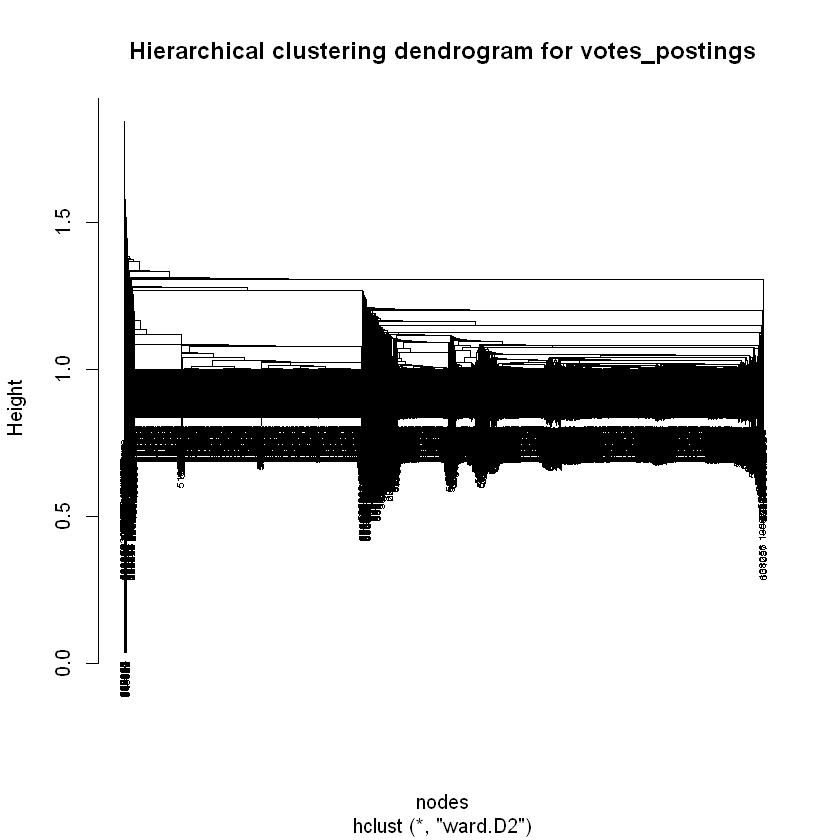

[1] "Average silhouette widths for all cluster numbers are too low. No meaningful clustering result for votes_postings"


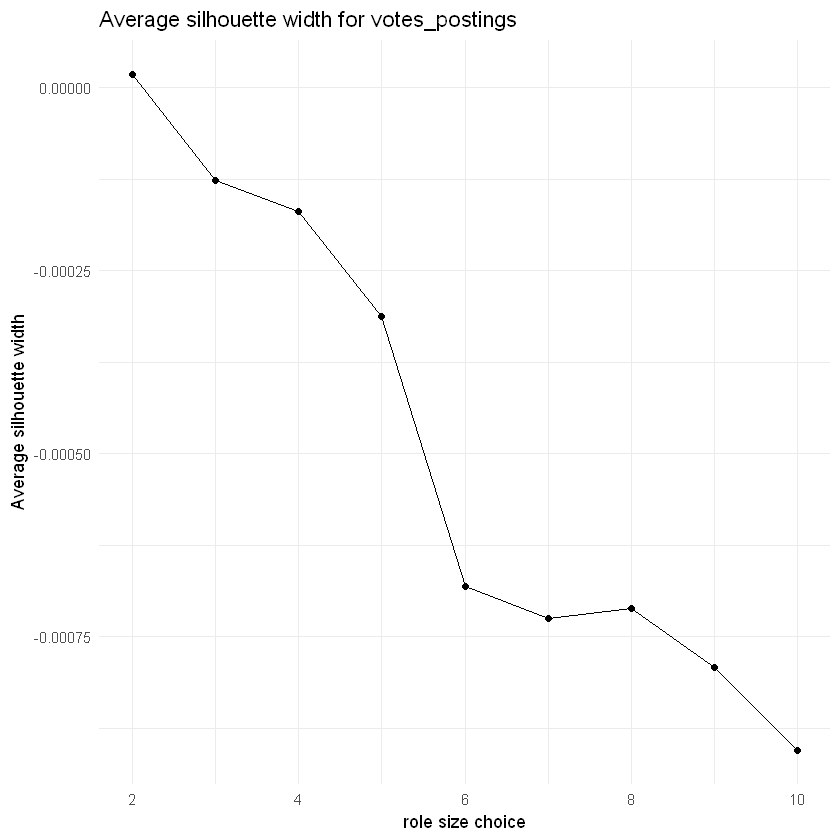

In [17]:
# types <- c("postings_replies", "votes_postings_unweighted", "votes_postings")
types <- c("votes_postings")
sims <- list()

for (type in types) {
  # sims[[type]] <- read_parquet(paste0("results/simrank/sr_",type,".parquet"))
  sims[[type]] <- read_parquet("C:/tmp/equivalence-based-network-role-mining/results/simrank/sr_votes_postings.parquet")
  sims[[type]] <- sims[[type]] %>% select(-last_col())
}

clustering(sims, types, "simrank")	

### RoleSim

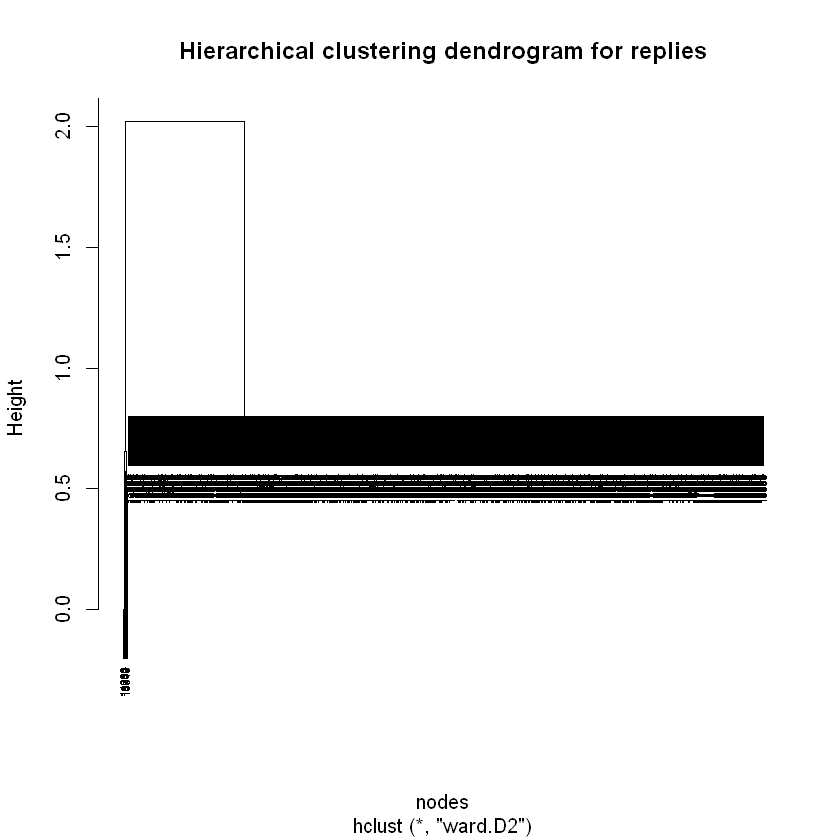

[1] "Average silhouette widths for all cluster numbers are too low. No meaningful clustering result for replies"


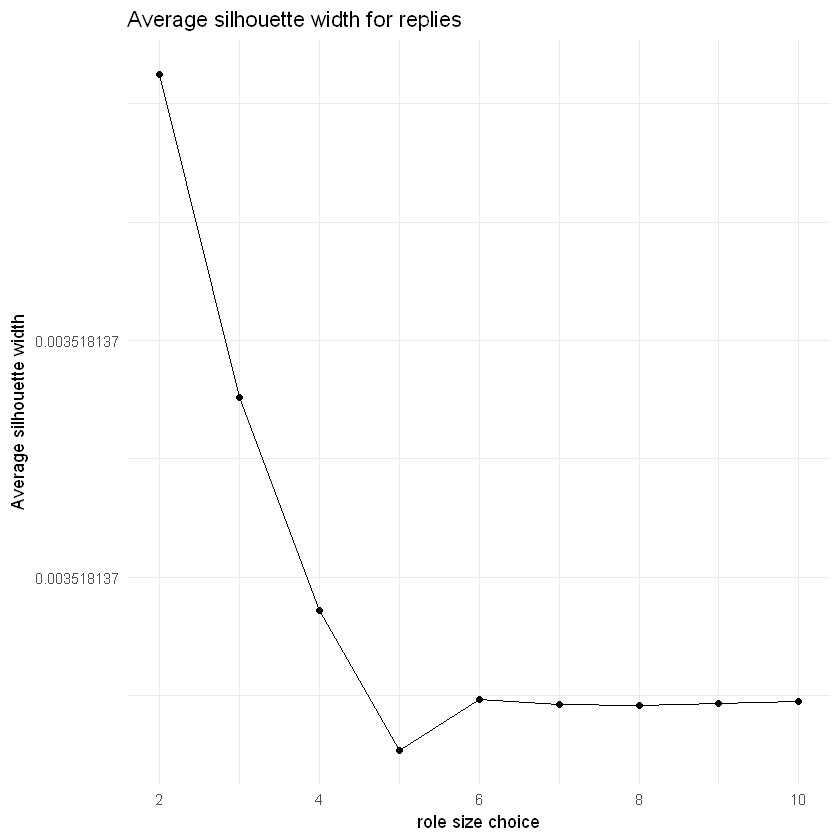

In [18]:
types <- c("replies") #, "votes", "follows")
sims <- list()
n <- 11323
for (type in types) {
  m <- read.csv(paste0("results/rolesim/",type,"-",n,"-dissimilarity-matrix.csv")) 
  sims[[type]] <- m %>% column_to_rownames(var = colnames(m)[1])
}

clustering(sims, types, "rolesim")

### REGE

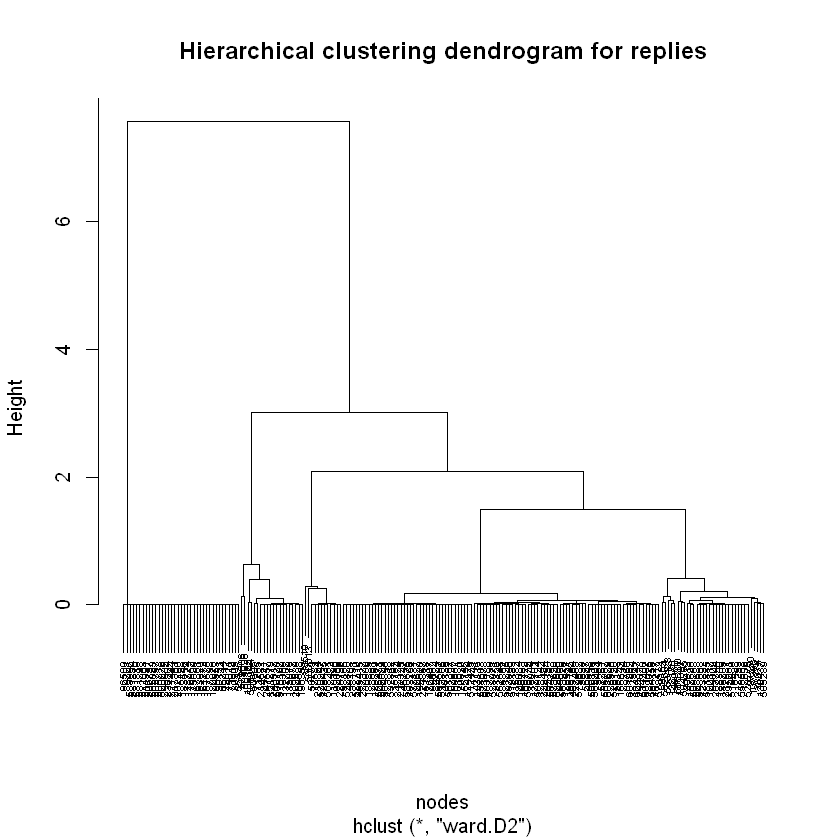

[1] "Best silhouette width for replies at role number k= 5"


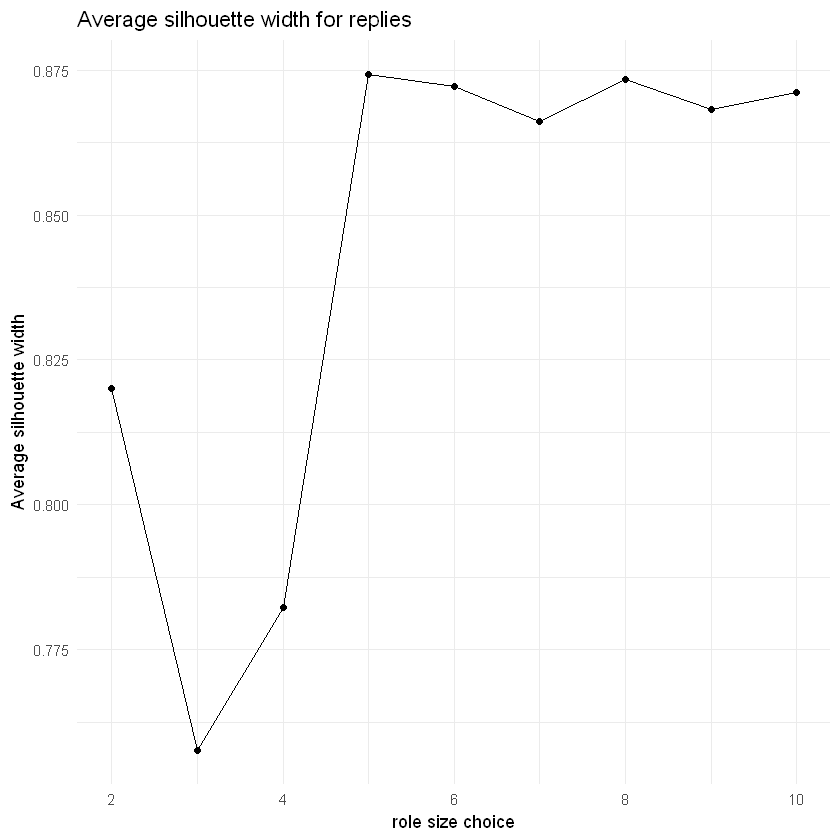

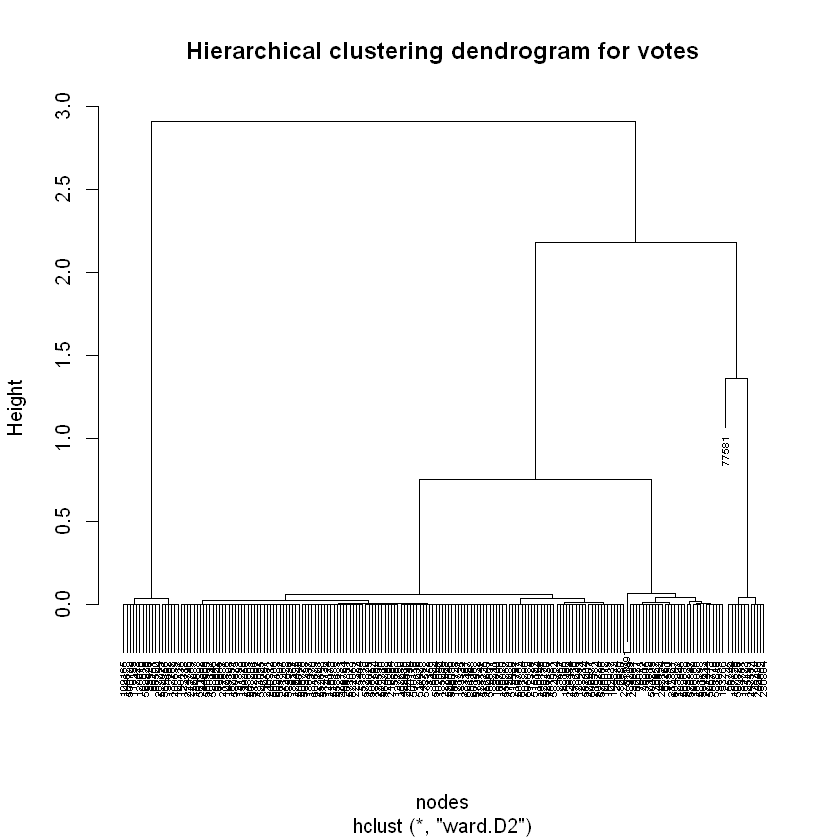

[1] "Best silhouette width for votes at role number k= 5"


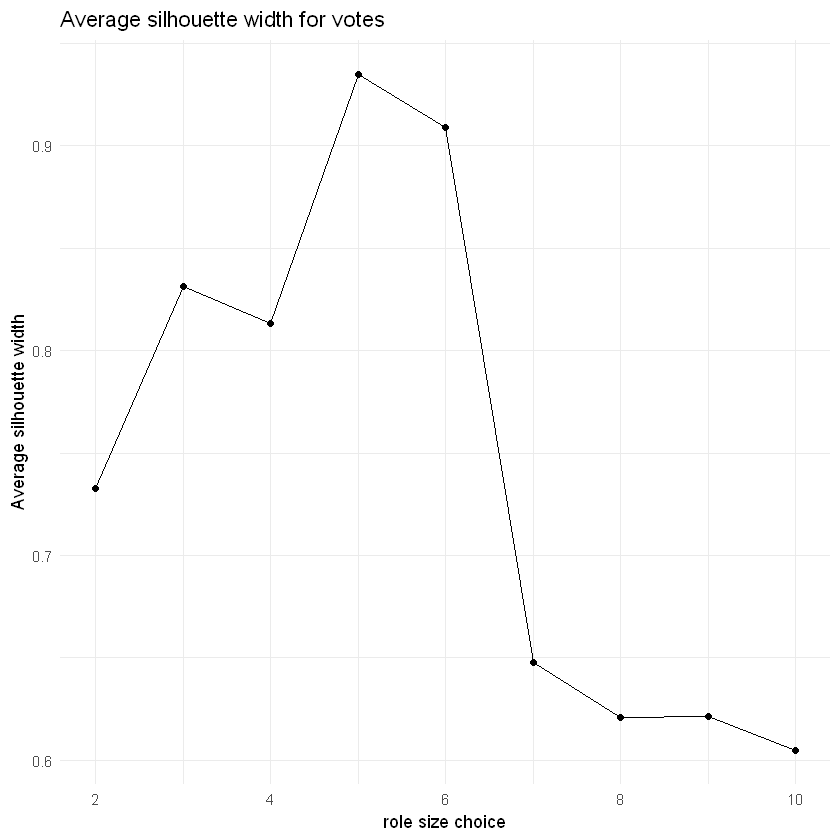

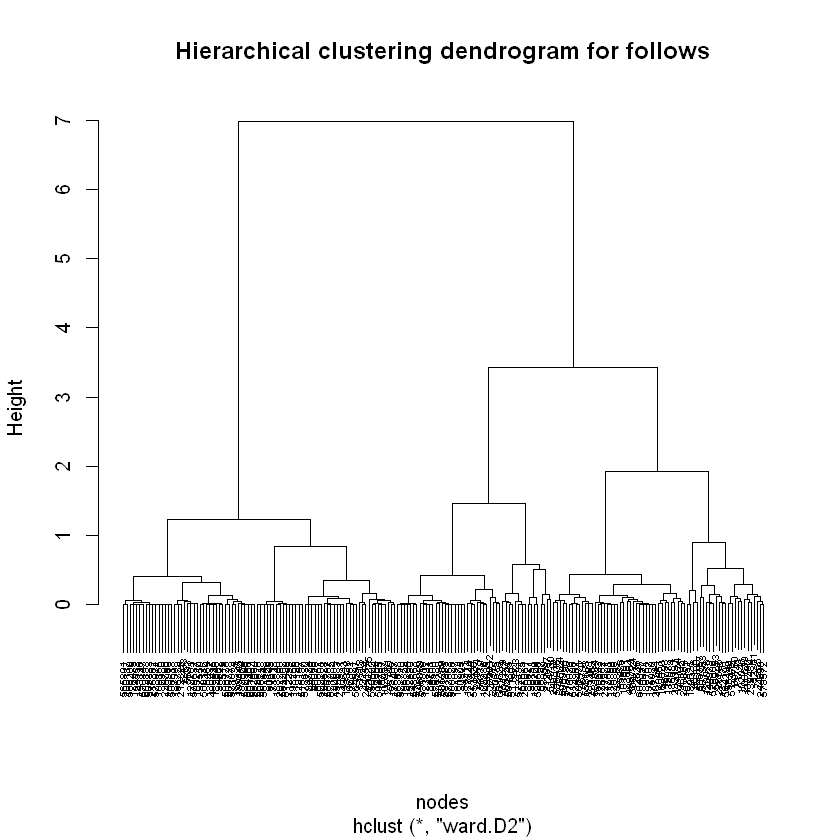

[1] "Best silhouette width for follows at role number k= 5"


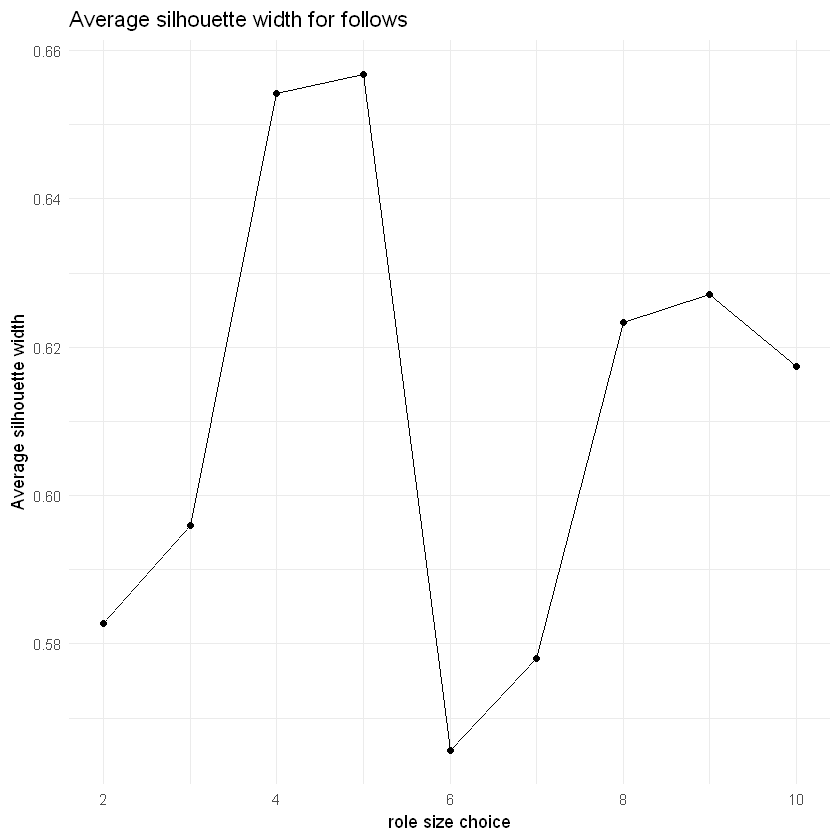

In [19]:
types <- c("replies", "votes", "follows")
sims <- list()
n <- 202
regeoutput <- readRDS(paste0("results/rege/rege-",n,".rds"))

for (type in types) {
  sims[[type]] <- regeoutput[[type]]
}

res <- clustering(sims, types, "rege")	